# <div align="center"><b> YOLOV11 - PROYECTO FINAL </b></div>

<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomendado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al siguiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/ruta/de/archivo.ipynb">Ruta archivo</a></font></small></em> </div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

<!-- Descargar archivos adicionales:
!gdown https://drive.google.com/drive/folders/1UBZ8PEbtmiWMGkULu7GAt3VhUpeTy9l7?usp=sharing --folder -->

In [1]:
# Chequear versión de CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [2]:
# Chequear más datos sobre la GPU
!nvidia-smi

Sun May 25 14:04:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8              5W /  320W |    1015MiB /  16376MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [ ]:
import sys, os, json, uuid
from dotenv import load_dotenv

load_dotenv("../../.env.dev")

sys.path.append(os.path.abspath("../../"))  # Se agrega utilidades generales del modulo IA
sys.path.append(os.path.abspath("../../../modulo-apps"))  # Se agrega modulo-mini-apps

from typing import List, Dict, Any, Optional
from pathlib import Path

from pprint import pprint

import ultralytics
from ultralytics import YOLO
from ultralytics.data.utils import visualize_image_annotations
from ultralytics.engine.results import Results
import torch

import pandas as pd

import fiftyone as fo

from apps_utils.logging import Logging
from apps_config.settings import Config
from apps_com_db.mongodb_client import MongoDB

import ia_utils.dataset_utils as DatasetUtils
import ia_utils.gpu_utils as GPUUtils
import ia_utils.yolo_dataset_utils as YoloDatasetUtils

from apps_com_s3.procesador_s3 import ProcesadorS3
import apps_etiquetado.procesador_anotaciones_mongodb as ProcesadorCocoDataset
import apps_etiquetado.procesador_anotaciones_coco_dataset as UtilsCocoDataset
import apps_etiquetado.visualizador_coco_dataset as VisualizadorCocoDataset
import apps_etiquetado.procesador_geojson_kml as ProcesadorGeojsonKml
import apps_etiquetado.procesador_anotaciones_mongodb as ProcesadorAnotacionesMongoDB

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [4]:
# Crear instancia de Config
CONFIG = Config().config_data
LOGGER = Logging().logger
DB = MongoDB().db

download_folder = Path(CONFIG["folders"]["download_folder"])
DOWNLOAD_RAW_DATASET_FOLDER = Path(CONFIG["folders"]["raw_dataset_folder"])
DOWNLOAD_YOLO_DATASET_FOLDER = Path(CONFIG["folders"]["yolo_dataset"])
DOWNLOAD_PREDICTION_FOLDER = download_folder / "predictions"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.

# Parámetros
BATCH_SIZE = 10  # Tamaño del batch
N_EPOCHS = 10  # Número de épocas
VERBOSE = True  # Muestra época a época la evolución
RANDOM_SEED = 42  # Semilla para la aleatoriedad

print(f"Dispositivo actual: {DEVICE}")
ultralytics.checks()  # Verifica la instalación de ultralytics

Ultralytics 8.3.140  Python-3.13.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
Setup complete  (20 CPUs, 127.9 GB RAM, 678.4/1862.9 GB disk)


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | YoloV11 - Detección de palmeras                                                                                                                |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Notebook de detección de palmeras utilizando YoloV11                                                                                                          |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

## Descarga del dataset

In [5]:
# DatasetUtils.download_full_dataset()

## Analisis de datos

### Convertir todas las clases a una sola

In [6]:
# coco_anotations = UtilsCocoDataset.load_annotations_from_file(DOWNLOAD_RAW_DATASET_FOLDER / "labels.json")
# coco_annotations_one_class = UtilsCocoDataset.parse_class_annotations_to(coco_anotations, "palmera")

# with open(DOWNLOAD_RAW_DATASET_FOLDER / "labels.json", "w") as f:
#     json.dump(coco_annotations_one_class, f, indent=4)
#     LOGGER.debug(f"Se guardó el archivo de etiquetas en {DOWNLOAD_RAW_DATASET_FOLDER / 'labels.json'}")

### Cargamos el dataset

> 📝 <em><font color='Gray'>Nota:</font></em> Si hay problema de versiones con `FiftyOne`, borrar la base de datos del mismo que se encuentra en: `C:\Users\<usuario>\.fiftyone\`</em>

In [7]:
# dataset_name = "deteccion-palmeras"
# dataset = fo.Dataset.from_dir(
#     dataset_type=fo.types.COCODetectionDataset,
#     dataset_dir=DOWNLOAD_RAW_DATASET_FOLDER,
#     overwrite=True,
#     name=dataset_name,
# )

### Observamos el dataset

In [8]:
# session = fo.launch_app(dataset, auto=False)

Accedemos a la visualización: <a>localhost:5151</a>

## Convertir dataset a formato YOLO
<small><em>https://docs.ultralytics.com/reference/cfg/__init__/</em></small>

In [9]:
# Path(DOWNLOAD_YOLO_DATASET_FOLDER).mkdir(parents=True, exist_ok=True)
# dataset.export(
#     export_dir=str(DOWNLOAD_YOLO_DATASET_FOLDER),
#     dataset_type=fo.types.YOLOv5Dataset,
#     overwrite=True,
#     split="full",
# )

Ejemplo con views splits:

```python
for split in splits:
    split_view = dataset_or_view.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )
```

Dividimos el conjunto de datos en train y test:

In [10]:
# YoloDatasetUtils.split_yolo_dataset(DOWNLOAD_YOLO_DATASET_FOLDER, (0.8, 0.2, 0.0))

Visualizamos algunas imagenes del conjunto de datos:

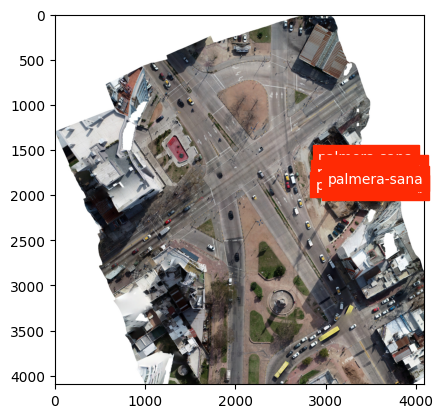

In [11]:
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0"
image_path = DOWNLOAD_YOLO_DATASET_FOLDER / "images" / "train" / f"{image_name}.jpg"
txt_path = DOWNLOAD_YOLO_DATASET_FOLDER / "labels" / "train" / f"{image_name}.txt"

categories = CONFIG["coco_dataset"]["categories"]
category_map = {cat["id"]: cat["name"] for cat in categories}

visualize_image_annotations(image_path, txt_path, category_map)

## Entrenamiento del modelo

Creamos el modelo de detección de objetos YOLOv11:

<small><em>https://docs.ultralytics.com/modes/train/#train-settings</em></small>

In [ ]:
# project_name = "deteccion_palmeras_yolo11x_8abcc8ff37d8"
# project_name = None

In [13]:
# model_name = "yolo11n"
model_name = "yolo11x"
model_path = model_name + ".pt"
project_name = f"deteccion_palmeras_{model_name}_{str(uuid.uuid4()).split('-')[-1]}" if not project_name else project_name

model = YOLO(model_path)
LOGGER.info(f"Ejecutando el entrenamiento del modelo {model_name} en el proyecto {project_name}")

2025-05-25 14:04:45,279 - root - INFO - <module> - Ejecutando el entrenamiento del modelo yolo11x en el proyecto deteccion_palmeras_yolo11x_8abcc8ff37d8


Imprimimos el modelo:

In [14]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

Mostramos información del modelo:

> 📝 <em><font color='Gray'>Nota:</font></em> $\text{Max batch size} = \frac{\text{Available GPU memory (bytes)}}{4 \times (\text{Size of tensors} + \text{Trainable parameters})}$


Max batch size = available GPU memory bytes / 4 / (size of tensors + trainable parameters)

In [15]:
print(f"Información básica del modelo:")
model.info()

Información básica del modelo:
YOLO11x summary: 357 layers, 56,966,176 parameters, 0 gradients, 196.0 GFLOPs


(357, 56966176, 0, 195.9587328)

Entrenamos el modelo:

In [ ]:
results = model.train(
    data=str(DOWNLOAD_YOLO_DATASET_FOLDER / "dataset.yaml"),
    epochs=100,
    batch=16,
    device=0,
    imgsz=1024,
    project=project_name,
    seed=CONFIG["seed"],
    exist_ok=True,
    save_period=1,
    # cache=True,
    # plots=True,
)

## Validación del modelo

Cargamos el mejor modelo:

In [17]:
print(f"Nombre del proyecto: {project_name}")
best_model_path = Path(project_name) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)
best_model = YOLO(best_model_path)

Nombre del proyecto: deteccion_palmeras_yolo11x_8abcc8ff37d8


Limpiamos la GPU:

In [18]:
GPUUtils.clean_gpu_usage()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 12% |  6% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 11% |  6% |


Validamos el modelo:

In [19]:
metrics = best_model.val(
    project=project_name,
    data=str(DOWNLOAD_YOLO_DATASET_FOLDER / "dataset.yaml")
)

Ultralytics 8.3.140  Python-3.13.3 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2829.8342.4 MB/s, size: 6037.2 KB)


val: Scanning E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\deteccion_palmeras\yolov11\downloads\yolo_dataset\labels\val.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


                   all         36        169     0.0336      0.355     0.0317     0.0114
Speed: 2.6ms preprocess, 30.8ms inference, 0.0ms loss, 9.3ms postprocess per image
Results saved to deteccion_palmeras_yolo11x_8abcc8ff37d8\val4


Imprimimos el reporte de validación:

In [20]:
metrics.summary()

[{'class_name': 'palmera',
  'box-p': np.float64(0.03361763515982158),
  'box-r': np.float64(0.35502958579881655),
  'box-f1': np.float64(0.06141947989175199),
  'box-map': np.float64(0.011420947929324594),
  'box-map50': np.float64(0.03166960104937968),
  'box-map75': np.float64(0.004355121147192705)}]

## Probamos la predicción

Cargamos el modelo:

In [21]:
print(f"Nombre del proyecto: {project_name}")
best_model_path = Path(project_name) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)
best_model = YOLO(best_model_path)

Nombre del proyecto: deteccion_palmeras_yolo11x_8abcc8ff37d8


### Parches

Descargamos el parche:

In [22]:
patch_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0"
Path(DOWNLOAD_PREDICTION_FOLDER).mkdir(parents=True, exist_ok=True)
patch_file_path = DOWNLOAD_PREDICTION_FOLDER / f"{patch_name}.jpg"
procesadorS3 = ProcesadorS3()
procesadorS3.download_patch_from_minio(patch_name, patch_file_path)
LOGGER.debug(f"Se descargó el parche {patch_file_path} desde MinIO")

Realizamos la predicción:

In [23]:
results = best_model.predict(patch_file_path, project=project_name, save=True, save_txt=True, name=patch_name)


image 1/1 e:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\deteccion_palmeras\yolov11\downloads\predictions\8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0.jpg: 1024x1024 84 palmeras, 104.5ms
Speed: 7.6ms preprocess, 104.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to deteccion_palmeras_yolo11x_8abcc8ff37d8\8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_03
1 label saved to deteccion_palmeras_yolo11x_8abcc8ff37d8\8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_03\labels


Obtenemos los resultados:

In [24]:
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box

    print(f"Resultados para el parche: {patch_name}")
    print(f"Cantidad de detecciones: {len(names)}")
    if len(names) == 0:
        print("No se detectaron objetos.")
    else:
        for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
            print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

Resultados para el parche: 8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0
Cantidad de detecciones: 84
Detección 1: Clase=palmera, Confianza=1.00, Caja=[2449.34130859375, 2790.39599609375, 2559.02880859375, 2893.029296875]
Detección 2: Clase=palmera, Confianza=1.00, Caja=[2240.083740234375, 191.60064697265625, 2304.070556640625, 283.65557861328125]
Detección 3: Clase=palmera, Confianza=1.00, Caja=[2270.308349609375, 2549.76806640625, 2354.436279296875, 2637.84716796875]
Detección 4: Clase=palmera, Confianza=1.00, Caja=[64.0, 3010.87646484375, 1600.0, 4096.0]
Detección 5: Clase=palmera, Confianza=1.00, Caja=[2880.0, 3255.8369140625, 4096.0, 4096.0]
Detección 6: Clase=palmera, Confianza=1.00, Caja=[1394.4151611328125, 4041.03271484375, 1475.5518798828125, 4096.0]
Detección 7: Clase=palmera, Confianza=0.99, Caja=[320.0, 3135.66845703125, 1856.0, 4096.0]
Detección 8: Clase=palmera, Confianza=0.99, Caja=[320.0, 0.0, 1856.0, 832.0]
Detección 9: Clase=palmera, Confianza=0.

Filtramos los resultados según la confianza:

In [25]:
confidence_threshold = 0.99  # Ajusta según necesidad

# Filtrar los índices según el umbral
filtered_indices = [i for i, conf in enumerate(result.boxes.conf) if conf.item() >= confidence_threshold]

# Filtrar las cajas y otros atributos
filtered_boxes = result.boxes[filtered_indices]

# Crear un nuevo objeto Results con las mismas propiedades pero solo con las detecciones filtradas
results_filtered = Results(
    orig_img=result.orig_img,
    path=result.path,
    names=result.names,
)
results_filtered.boxes = filtered_boxes
results_filtered.orig_shape = result.orig_shape
results_filtered.speed = result.speed
results_filtered.save_dir = result.save_dir

# Si necesitas una lista como results:
results_filtered_list = [results_filtered]

Mostramos los resultados filtrados:

In [26]:
for result in results_filtered_list:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box

    print(f"Resultados para el parche: {patch_name}")
    print(f"Cantidad de detecciones: {len(names)}")
    if len(names) == 0:
        print("No se detectaron objetos.")
    else:
        for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
            print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

Resultados para el parche: 8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_patch_0
Cantidad de detecciones: 8
Detección 1: Clase=palmera, Confianza=1.00, Caja=[2449.34130859375, 2790.39599609375, 2559.02880859375, 2893.029296875]
Detección 2: Clase=palmera, Confianza=1.00, Caja=[2240.083740234375, 191.60064697265625, 2304.070556640625, 283.65557861328125]
Detección 3: Clase=palmera, Confianza=1.00, Caja=[2270.308349609375, 2549.76806640625, 2354.436279296875, 2637.84716796875]
Detección 4: Clase=palmera, Confianza=1.00, Caja=[64.0, 3010.87646484375, 1600.0, 4096.0]
Detección 5: Clase=palmera, Confianza=1.00, Caja=[2880.0, 3255.8369140625, 4096.0, 4096.0]
Detección 6: Clase=palmera, Confianza=1.00, Caja=[1394.4151611328125, 4041.03271484375, 1475.5518798828125, 4096.0]
Detección 7: Clase=palmera, Confianza=0.99, Caja=[320.0, 3135.66845703125, 1856.0, 4096.0]
Detección 8: Clase=palmera, Confianza=0.99, Caja=[320.0, 0.0, 1856.0, 832.0]


Convertimos los resultados a anotaciones:

In [27]:
coco_annotations = YoloDatasetUtils.create_coco_annotations_from_yolo_results(results_filtered_list, patch_name)
print("Anotaciones COCO:")
pprint(coco_annotations)

Anotaciones COCO:
{'annotations': [{'area': 11257.58984375,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [2449.34130859375,
                           2790.39599609375,
                           109.6875,
                           102.63330078125],
                  'category_id': 4,
                  'confidence': 0.9999738931655884,
                  'id': 1,
                  'image_id': 1,
                  'iscrowd': 0},
                 {'area': 5890.30224609375,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [2240.083740234375,
                           191.60064697265625,
                           63.98681640625,
                           92.054931640625],
                  'category_id': 4,
                  'confidence': 0.9997863173484802,
                  'id': 2,
                  'image_id': 1,
                  'iscrowd': 0},
                 {'area': 7409.9125976562

Visualizamos los resultados:

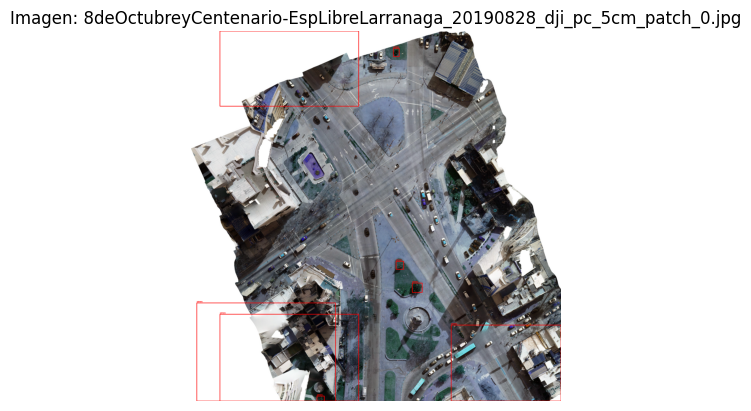

In [28]:
VisualizadorCocoDataset.show_anotated_image(image_path=patch_file_path, coco_annotations=coco_annotations)

#### Generar KML

In [29]:
jgw_data = ProcesadorAnotacionesMongoDB.load_jgw_file_from_mongodb(patch_name=patch_name)
pprint(jgw_data)

{'x_origin': 577344.7165226148,
 'x_pixel_size': 0.05,
 'x_rotation': 0.0,
 'y_origin': 6139798.10234485,
 'y_pixel_size': -0.05,
 'y_rotation': 0.0}


In [30]:
gdf = ProcesadorGeojsonKml.create_geojson_from_annotation(patch_name, coco_annotations, jgw_data)
gdf.head()

,category,annotation_id,bbox_x,bbox_y,bbox_width,bbox_height,global_tl_x,global_tl_y,global_br_x,global_br_y,geometry
0,palmera,1,2449.341309,2790.395996,109.687500,102.633301,577467.183588,6.139659e+06,577472.667963,6.139653e+06,POINT (577469.926 6139656.017)
1,palmera,2,2240.083740,191.600647,63.986816,92.054932,577456.720710,6.139789e+06,577459.920050,6.139784e+06,POINT (577458.32 6139786.221)
2,palmera,3,2270.308350,2549.768066,84.127930,88.079102,577458.231940,6.139671e+06,577462.438337,6.139666e+06,POINT (577460.335 6139668.412)
3,palmera,4,64.000000,3010.876465,1536.000000,1085.123535,577347.916523,6.139648e+06,577424.716523,6.139593e+06,POINT (577386.317 6139620.43)
4,palmera,5,2880.000000,3255.836914,1216.000000,840.163086,577488.716523,6.139635e+06,577549.516523,6.139593e+06,POINT (577519.117 6139614.306)


In [31]:
kml = ProcesadorGeojsonKml.convert_kml_from_geojson(gdf)

2025-05-25 14:05:13,478 - root - INFO - convert_kml_from_geojson - Archivo KML guardado en downloads\kmls\kml_palmera_20250525140513.kml


### Imagen

In [ ]:
# TODO: Ver para imagenes

## Estadísticas entrenamiento

In [ ]:
df = pd.read_csv("entrenamientos.csv")
df

,Modelo,Epocas,Batch,Imgsz,LR,Earlystopping,Epoca final,Tiempo (min),Proyecto
0,yolo11x,100,1,1,default,-,-,50,deteccion_palmeras_yolo11x_8abcc8ff37d8
